In [1]:
import pandas as pd
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import numpy as np
from constant import AFFECTNETPATH

In [80]:
class ImageDataset(Dataset):
    def __init__(self, csv_file,base_path,transform=None):
        self.fields = ['subDirectory_filePath', 'expression','valence','arousal']
        self._table = pd.read_csv(csv_file,usecols=self.fields)
        
        self._table=self._table[self._table['expression'] <8]

        self._table=self._table.reset_index(drop=True)

        self._base_path=base_path
   



        self.transform=transforms.Compose([
                     transforms.Resize((64,64)),
                     transforms.ToTensor(),   
                     transforms.Normalize((0.5,0.5,0.5 ), (0.5, 0.5,0.5))])

    def __len__(self):
        return len(self._table)

    def __getitem__(self, idx):
        folder_name = os.path.join(self._base_path,self._table.subDirectory_filePath[idx])
        img=Image.open(folder_name)
        img=self.transform(img)
        valence = torch.from_numpy(np.array(self._table.valence[idx]))
        return (img,valence.float())
            
        

In [81]:
Affect_Train=ImageDataset('training.csv',AFFECTNETPATH)
Affect_Valid=ImageDataset('validation.csv',AFFECTNETPATH)

In [82]:
len(Affect_Train)

287652

In [76]:
import csv
def import_data(filename):
    """Import data in the second column of the supplied filename as floats."""
    with open(filename, 'r') as inf:
        inf.readline()
        return [float(row[2]) for row in csv.reader(inf)]

In [77]:
df=import_data("train_filtered.csv")
len(df)

320739

(0.0, 23900.0)

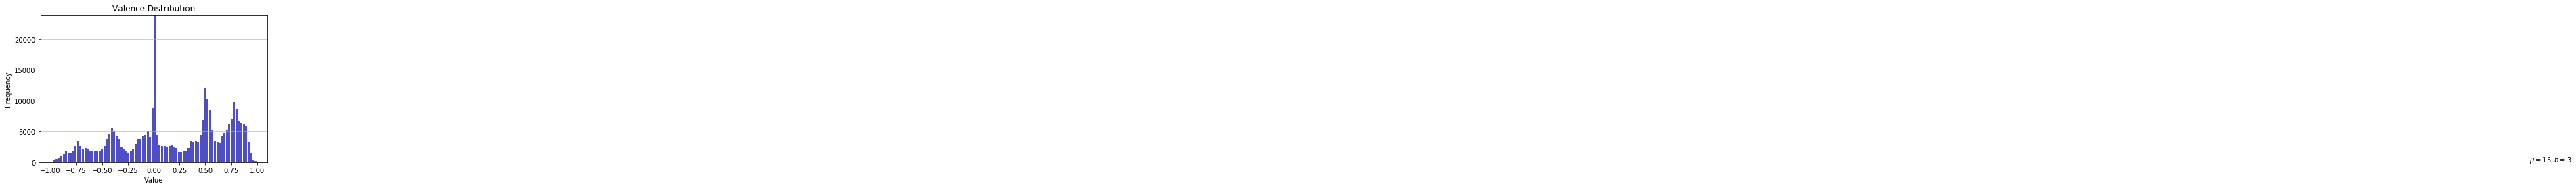

In [67]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=np.array(df), bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Valence Distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [68]:
len(Affect_Train)

283902

In [8]:
train_dataloader = DataLoader(Affect_Train, batch_size=512
                       , num_workers=0,shuffle=True)

valid_dataloader = DataLoader(Affect_Valid, batch_size=512
                       , num_workers=0)    

In [50]:
len(train_dataloader)

NameError: name 'train_dataloader' is not defined

In [ ]:
Affect_Train[0][0].shape

In [10]:
from module import face_feature

In [11]:
model=face_feature.Face_Feature()
model=model.to(device)

In [12]:
model(Affect_Train[0][0].unsqueeze(0).to(device))

(tensor([[0.3269]], grad_fn=<TanhBackward>),
 tensor([[0.3715]], grad_fn=<TanhBackward>))

In [13]:
loss_func = torch.nn.MSELoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0005, betas=(0.5, 0.999))

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.set_default_tensor_type(torch.cuda.FloatTensor)

In [ ]:
train_loss=[]
val_loss=[]
num_epochs=50

model.train()
for epochs in range(0,num_epochs):
    model.train()
    print("Training Epoch: ", epochs+1,"\n")
   
    for i_batch, (img,valence) in enumerate(train_dataloader):
        
        batch_size=img.size(0)
        optimizer.zero_grad()
        img=img.to(device)
        val_output,arou_output=model(img)
        loss1=loss_func(val_output,valence.to(device))
        loss=loss1+loss2
        loss.backward()
        optimizer.step()
        if i_batch%500==0:
            print("Batch: ",i_batch+1,"/",len(train_dataloader))
            print("MSE loss: ", loss.item())
            train_loss.append(loss.item())
    model.eval()
    avg_loss=1e6
    temp_loss=0
    for i_batch, (img,valence,arousal) in enumerate(valid_dataloader):
        
        batch_size=img.size(0)

        img=img.to(device)
        val_output,arou_output=model(img)
        loss1=loss_func(val_output,valence.to(device))
        loss2=loss_func(arou_output,valence.to(device))
        loss=loss1+loss2
        temp_loss+=loss.item()
    print("ValidationLoss: ",temp_loss/len(valid_dataloader))
    val_loss.append(temp_loss/len(valid_dataloader))
    if temp_loss<avg_loss:
        avg_loss=temp_loss
        torch.save(model,"face_feature.h")
    

    

    
        

/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Batch:  1 / 627
MSE loss:  0.5999425649642944
Batch:  501 / 627
MSE loss:  0.5151660442352295


/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([228])) that is different to the input size (torch.Size([228, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([404])) that is different to the input size (torch.Size([404, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/opt/conda/envs/torch/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Face_Feature. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/envs/torch/lib/p

ValidationLoss:  0.6498083538479276
Training Epoch:  1 

Batch:  1 / 627
MSE loss:  0.5167564153671265
Batch:  501 / 627
MSE loss:  0.4954649806022644
ValidationLoss:  0.770111428366767
Training Epoch:  2 

Batch:  1 / 627
MSE loss:  0.5344341993331909


In [ ]:
avg_loss=1e6

In [ ]:
avg_loss

In [ ]:
print("hu")